In [1]:
import scipy.io
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# input data and preprocessing

The noise in the signals has already been removed, and the preprocessing part has been handled before I received the data.

In [5]:
def load_mat_files(directory):

  all_babies_data = []

  for filename in sorted(os.listdir(directory), key=lambda x: int(re.search(r'\d+', x).group())):
    if filename.endswith(".mat"):
      file_path = os.path.join(directory, filename)
      mat = scipy.io.loadmat(file_path)

      # (channels, time, epochs)
      eeg_data = mat['EEG_Seg']
      each_baby_epochs = [eeg_data[:, :, i] for i in range(eeg_data.shape[2])]

      all_babies_data.append(each_baby_epochs)

  return all_babies_data


In [6]:
healthy_dir = "/content/drive/MyDrive/Healthy"
disorder_dir = "/content/drive/MyDrive/Disorder"

In [7]:
healthy_data = load_mat_files(healthy_dir)
disorder_data = load_mat_files(disorder_dir)


In [8]:
len(healthy_data)

12

In [9]:
len(healthy_data[0]) # number of epochs for first healthy baby

88

In [10]:
healthy_data[0][0].shape

(62, 250)

# feature extraction

## correlation matrix(pearson correlation)

In [ ]:
def correlation_matrices(data):
  all_corrs = []

  for baby in data:
    each_baby_corr = []

    for epoch in baby:
      # epoch shape: (channels, time_points)
      corr_matrix = np.corrcoef(epoch)
      corr_matrix = np.abs(corr_matrix)
      each_baby_corr.append(corr_matrix)

    all_corrs.append(each_baby_corr)
  return all_corrs

In [ ]:
correlation_matrice_healthy = correlation_matrices(healthy_data)
correlation_matrice_disorder = correlation_matrices(disorder_data)

In [ ]:
len(correlation_matrice_healthy[0]) # must be number of epochs for first healthy baby which is equal to 88

88

In [ ]:
correlation_matrice_healthy[0][0].shape # must be (n_channels, n_channels)

(62, 62)

In [ ]:
correlation_matrice_healthy[0]

[array([[1.        , 0.71407391, 0.7591303 , ..., 0.91657389, 0.81051145,
         0.78694826],
        [0.71407391, 1.        , 0.93380792, ..., 0.54571567, 0.87788144,
         0.86470363],
        [0.7591303 , 0.93380792, 1.        , ..., 0.60254992, 0.90649814,
         0.94250181],
        ...,
        [0.91657389, 0.54571567, 0.60254992, ..., 1.        , 0.67890863,
         0.66118926],
        [0.81051145, 0.87788144, 0.90649814, ..., 0.67890863, 1.        ,
         0.95199246],
        [0.78694826, 0.86470363, 0.94250181, ..., 0.66118926, 0.95199246,
         1.        ]]),
 array([[1.        , 0.82106473, 0.53120551, ..., 0.41896494, 0.8669139 ,
         0.67644363],
        [0.82106473, 1.        , 0.86467857, ..., 0.30179837, 0.90723364,
         0.8940532 ],
        [0.53120551, 0.86467857, 1.        , ..., 0.05644058, 0.80296567,
         0.94871488],
        ...,
        [0.41896494, 0.30179837, 0.05644058, ..., 1.        , 0.34182245,
         0.13385654],
        [0.8

## Phase Lag Index(PLI)

In [ ]:
from scipy.signal import hilbert

In [ ]:
def phase_lag_index(data):
  all_pli=[]

  for baby in data:
    baby_pli=[]

    for epoch in baby:
      n_channels = epoch.shape[0]
      pli_matrix = np.zeros((n_channels, n_channels))

      analytic_signal = np.array([hilbert(channel) for channel in epoch]) # apply Hilbert transform to get the analytic signal
      phase_data = np.angle(analytic_signal)

      for i in range(n_channels):
        for j in range(i + 1, n_channels):
          phase_diff = phase_data[i] - phase_data[j] # compute phase difference
          pli = np.abs(np.mean(np.sign(np.sin(phase_diff)))) # compute PLI
          pli_matrix[i, j] = pli
          pli_matrix[j, i] = pli # because PLI is symmetric

      baby_pli.append(pli_matrix)
    all_pli.append(baby_pli)

  return all_pli


In [ ]:
PLI_healthy = phase_lag_index(healthy_data)
PLI_disorder = phase_lag_index(disorder_data)

In [ ]:
len(PLI_healthy) # must be number of healthy babies which is equal to 12

12

In [ ]:
len(PLI_healthy[0]) # must be number of epochs for first healthy baby which is equal to 88

88

In [ ]:
PLI_healthy[0][0].shape # must be (n_channels, n_channels)

(62, 62)

In [ ]:
PLI_healthy[0]

[array([[0.   , 0.352, 0.4  , ..., 0.568, 0.632, 0.448],
        [0.352, 0.   , 0.216, ..., 0.536, 0.136, 0.088],
        [0.4  , 0.216, 0.   , ..., 0.48 , 0.336, 0.056],
        ...,
        [0.568, 0.536, 0.48 , ..., 0.   , 0.72 , 0.512],
        [0.632, 0.136, 0.336, ..., 0.72 , 0.   , 0.28 ],
        [0.448, 0.088, 0.056, ..., 0.512, 0.28 , 0.   ]]),
 array([[0.   , 0.36 , 0.68 , ..., 0.408, 0.416, 0.584],
        [0.36 , 0.   , 0.712, ..., 0.248, 0.2  , 0.264],
        [0.68 , 0.712, 0.   , ..., 0.136, 0.704, 0.6  ],
        ...,
        [0.408, 0.248, 0.136, ..., 0.   , 0.352, 0.232],
        [0.416, 0.2  , 0.704, ..., 0.352, 0.   , 0.584],
        [0.584, 0.264, 0.6  , ..., 0.232, 0.584, 0.   ]]),
 array([[0.   , 0.024, 0.176, ..., 0.296, 0.128, 0.184],
        [0.024, 0.   , 0.072, ..., 0.136, 0.064, 0.12 ],
        [0.176, 0.072, 0.   , ..., 0.048, 0.024, 0.144],
        ...,
        [0.296, 0.136, 0.048, ..., 0.   , 0.336, 0.032],
        [0.128, 0.064, 0.024, ..., 0.336, 0. 

## Phase Locking Value(PLV)

In [ ]:
def plv(data):
  all_plv = []

  for baby in data:
    each_baby_plv = []

    for epoch in baby:
      n_channels = epoch.shape[0]
      plv_matrix = np.zeros((n_channels, n_channels))

      analytic_signal = np.array([hilbert(channel) for channel in epoch])
      phase_data = np.angle(analytic_signal)

      for i in range(n_channels):
        for j in range(i + 1, n_channels):
          phase_diff = phase_data[i] - phase_data[j]
          plv = np.abs(np.mean(np.exp(1j * phase_diff)))
          plv_matrix[i, j] = plv
          plv_matrix[j, i] = plv  # because PLV  is symmetric

      each_baby_plv.append(plv_matrix)

    all_plv.append(each_baby_plv)

  return all_plv

In [ ]:
plv_healthy = plv(healthy_data)
plv_disorder = plv(disorder_data)


In [ ]:
len(plv_healthy) # must be number of healthy babies which is equal to 12

12

In [ ]:
len(plv_healthy[0]) # must be number of epochs for first healthy baby which is equal to 88

88

In [ ]:
plv_healthy[0][0].shape # must be (n_channels, n_channels)

(62, 62)

# Convert matrix to graph

In [ ]:
import networkx as nx

In [ ]:
def matrix_to_graph(matrix, threshold=0.5):

  G = nx.Graph()
  n = matrix.shape[0]
  for i in range(n):
    G.add_node(i)

  for i in range(n):
    for j in range(i + 1, n):
      weight = matrix[i, j]
      if weight > threshold:
        G.add_edge(i, j, weight=weight)

  return G


# Extract graph features

In [ ]:
def extract_graph_features(G):
    features = {}

    # global features
    if nx.is_connected(G):
        features["avg_shortest_path"] = nx.average_shortest_path_length(G, weight="weight")
    else:
        features["avg_shortest_path"] = np.nan

    features["density"] = nx.density(G)
    features["avg_clustering"] = nx.average_clustering(G, weight="weight")
    features["avg_degree"] = np.mean([d for _, d in G.degree()])

    # local features (per node)
    degrees = dict(G.degree())
    clustering = nx.clustering(G, weight="weight")
    betweenness = nx.betweenness_centrality(G, weight="weight")
    eigenvector = nx.eigenvector_centrality(G, weight="weight", max_iter=5000)

    for node in G.nodes():
        features[f"deg_{node}"] = degrees[node]
        features[f"clust_{node}"] = clustering[node]
        features[f"btw_{node}"] = betweenness[node]
        features[f"eig_{node}"] = eigenvector[node]

    return features


# convert matrix to graph and extract the graph features

In [ ]:
def process_all(connectivity_data, threshold=0.5):
    all_features = []

    for baby in connectivity_data:
        each_baby_features = []

        for epoch in baby:
            G = matrix_to_graph(epoch, threshold=threshold)
            features = extract_graph_features(G)
            each_baby_features.append(features)

        all_features.append(each_baby_features)

    return all_features


## convert correlation matrices to graph and extract its features



In [ ]:
corr_features_healthy = process_all(correlation_matrices_healthy, threshold=0.5)
corr_features_disorder = process_all(correlation_matrices_disorder, threshold=0.5)

In [ ]:
type(corr_features_disorder)

list

# convert PLI to graph and extract its features


In [ ]:
pli_features_healthy = process_all(pli_healthy, threshold=0.6)
pli_features_disorder = process_all(pli_disorder, threshold=0.6)


# convert PLV to graph and extract its features


In [ ]:
plv_features_healthy = process_all(plv_healthy, threshold=0.5)
plv_features_disorder = process_all(plv_disorder, threshold=0.5)


# compute mean of graph features over all epochs

In [ ]:
def mean_of_features(list_of_babies):
  mean = []

  for baby in list_of_babies:
    sum_dict = {}
    count_dict = {}

    for features_dict in baby:
      for key, value in features_dict.items():
        if key in sum_dict:
          sum_dict[key] += value
          count_dict[key] += 1
        else:
          sum_dict[key] = value
          count_dict[key] = 1

    average_dict = {key: sum_dict[key] / count_dict[key] for key in sum_dict}
    mean.append(average_dict)

  return mean


## compute mean of graph features of correlation matrices over all epochs

In [ ]:
mean_of_corr_features_healthy = mean_of_features(corr_features_healthy)

In [ ]:
len(mean_of_corr_features_healthy)

12

In [ ]:
mean_of_corr_features_healthy = pd.DataFrame(mean_of_corr_features_healthy)

In [ ]:
mean_of_corr_features_healthy["label"] = [0]*len(mean_of_corr_features_healthy)

In [ ]:
mean_of_corr_features_healthy

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.324293,0.421500,19.781891,16.170455,0.407931,0.015462,0.080777,27.750000,0.481853,...,0.047257,23.534091,0.471846,0.013723,0.131653,26.988636,0.493052,0.011519,0.163457,0
1,NaN,0.282060,0.415033,17.205645,16.857143,0.396646,0.020585,0.098623,19.883929,0.410752,...,0.080375,13.482143,0.393809,0.017501,0.075082,20.482143,0.440598,0.015896,0.135040,0
2,NaN,0.263796,0.397310,16.091543,10.891892,0.340428,0.014503,0.056499,20.040541,0.449625,...,0.056681,19.040541,0.439713,0.017907,0.118382,23.337838,0.457114,0.017095,0.168677,0
3,NaN,0.280727,0.415120,17.124368,19.927711,0.414483,0.019014,0.118673,18.337349,0.435062,...,0.057234,24.072289,0.404648,0.025222,0.149835,24.578313,0.459240,0.018184,0.161269,0
4,NaN,0.274393,0.409216,16.737953,18.567901,0.422209,0.018431,0.114917,17.234568,0.424990,...,0.053221,19.419753,0.419511,0.021514,0.120923,24.975309,0.426216,0.021365,0.166427,0
5,NaN,0.285767,0.400884,17.431811,14.851485,0.430300,0.013364,0.088421,24.702970,0.401606,...,0.092124,11.277228,0.404367,0.008110,0.064976,20.158416,0.429849,0.016875,0.125606,0
6,NaN,0.276891,0.407324,16.890323,19.981818,0.396561,0.027690,0.122728,22.836364,0.449752,...,0.053274,24.600000,0.446609,0.017377,0.171522,25.327273,0.458012,0.012757,0.181493,0
7,NaN,0.259626,0.401836,15.837174,12.833333,0.365836,0.020817,0.081234,22.761905,0.421719,...,0.086196,19.785714,0.439845,0.014741,0.137161,19.500000,0.444537,0.015170,0.133494,0
8,NaN,0.269608,0.405564,16.446105,13.365854,0.405385,0.015527,0.075894,24.195122,0.418708,...,0.094121,21.707317,0.418459,0.019112,0.137838,19.902439,0.461085,0.016220,0.124066,0
9,NaN,0.214519,0.371348,13.085663,12.033333,0.367722,0.020134,0.083650,16.422222,0.383210,...,0.079093,13.444444,0.371280,0.019587,0.102627,13.666667,0.380653,0.019375,0.106321,0


In [ ]:
mean_of_corr_features_disorder = mean_of_features(corr_features_disorder)

In [ ]:
len(mean_of_corr_features_disorder)

12

In [ ]:
mean_of_corr_features_disorder = pd.DataFrame(mean_of_corr_features_disorder)

In [ ]:
mean_of_corr_features_disorder["label"] = [1]*len(mean_of_corr_features_disorder)

In [ ]:
mean_of_corr_features_disorder

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.294941,0.407745,17.991373,16.720930,0.426985,0.012594,0.103876,20.825581,0.459292,...,0.066480,17.779070,0.410592,0.018852,0.103494,20.127907,0.436535,0.014811,0.124204,1
1,NaN,0.249592,0.382491,15.225120,12.191489,0.360020,0.017603,0.081849,21.744681,0.403194,...,0.069279,13.382979,0.403066,0.014708,0.090591,21.829787,0.433987,0.019393,0.167640,1
2,NaN,0.294860,0.408961,17.986472,23.370968,0.470613,0.008206,0.150735,22.387097,0.475657,...,0.085068,23.419355,0.466886,0.011132,0.150312,26.500000,0.453987,0.014930,0.173058,1
3,NaN,0.287671,0.415861,17.547957,10.906667,0.391959,0.011220,0.056625,23.306667,0.474237,...,0.068186,20.546667,0.479398,0.015220,0.126363,24.253333,0.465239,0.013530,0.160905,1
4,NaN,0.248828,0.397659,15.178495,19.266667,0.431998,0.020947,0.146504,22.400000,0.481215,...,0.069663,20.133333,0.491770,0.016248,0.165176,24.866667,0.432012,0.021475,0.204024,1
5,NaN,0.304111,0.410869,18.550777,13.074074,0.400894,0.013074,0.057536,19.222222,0.413660,...,0.039633,20.574074,0.382759,0.017436,0.104829,22.833333,0.415154,0.017375,0.136383,1
6,NaN,0.231491,0.383447,14.120968,11.750000,0.315335,0.016086,0.075197,19.062500,0.398148,...,0.094024,13.500000,0.364822,0.011544,0.084676,10.000000,0.369619,0.016120,0.062730,1
7,NaN,0.299634,0.408361,18.277700,15.159420,0.390241,0.015190,0.080286,22.028986,0.443521,...,0.056877,17.594203,0.420163,0.011167,0.101573,19.971014,0.431530,0.015229,0.119760,1
8,NaN,0.293896,0.405428,17.927650,13.385714,0.383682,0.013638,0.068861,21.628571,0.439129,...,0.061857,17.414286,0.406647,0.014879,0.092294,19.671429,0.437931,0.014223,0.113415,1
9,NaN,0.214884,0.359687,13.107940,10.884615,0.366290,0.013756,0.075949,12.500000,0.329034,...,0.077419,11.423077,0.347945,0.017182,0.085415,14.576923,0.374736,0.020177,0.118418,1


In [ ]:
mean_of_corr_features = pd.concat([mean_of_corr_features_healthy, mean_of_corr_features_disorder], axis=0, ignore_index=True)

In [ ]:
mean_of_corr_features

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.324293,0.421500,19.781891,16.170455,0.407931,0.015462,0.080777,27.750000,0.481853,...,0.047257,23.534091,0.471846,0.013723,0.131653,26.988636,0.493052,0.011519,0.163457,0
1,NaN,0.282060,0.415033,17.205645,16.857143,0.396646,0.020585,0.098623,19.883929,0.410752,...,0.080375,13.482143,0.393809,0.017501,0.075082,20.482143,0.440598,0.015896,0.135040,0
2,NaN,0.263796,0.397310,16.091543,10.891892,0.340428,0.014503,0.056499,20.040541,0.449625,...,0.056681,19.040541,0.439713,0.017907,0.118382,23.337838,0.457114,0.017095,0.168677,0
3,NaN,0.280727,0.415120,17.124368,19.927711,0.414483,0.019014,0.118673,18.337349,0.435062,...,0.057234,24.072289,0.404648,0.025222,0.149835,24.578313,0.459240,0.018184,0.161269,0
4,NaN,0.274393,0.409216,16.737953,18.567901,0.422209,0.018431,0.114917,17.234568,0.424990,...,0.053221,19.419753,0.419511,0.021514,0.120923,24.975309,0.426216,0.021365,0.166427,0
5,NaN,0.285767,0.400884,17.431811,14.851485,0.430300,0.013364,0.088421,24.702970,0.401606,...,0.092124,11.277228,0.404367,0.008110,0.064976,20.158416,0.429849,0.016875,0.125606,0
6,NaN,0.276891,0.407324,16.890323,19.981818,0.396561,0.027690,0.122728,22.836364,0.449752,...,0.053274,24.600000,0.446609,0.017377,0.171522,25.327273,0.458012,0.012757,0.181493,0
7,NaN,0.259626,0.401836,15.837174,12.833333,0.365836,0.020817,0.081234,22.761905,0.421719,...,0.086196,19.785714,0.439845,0.014741,0.137161,19.500000,0.444537,0.015170,0.133494,0
8,NaN,0.269608,0.405564,16.446105,13.365854,0.405385,0.015527,0.075894,24.195122,0.418708,...,0.094121,21.707317,0.418459,0.019112,0.137838,19.902439,0.461085,0.016220,0.124066,0
9,NaN,0.214519,0.371348,13.085663,12.033333,0.367722,0.020134,0.083650,16.422222,0.383210,...,0.079093,13.444444,0.371280,0.019587,0.102627,13.666667,0.380653,0.019375,0.106321,0


## compute mean of graph features of phase lag index over all epochs

In [ ]:
mean_of_pli_features_healthy = mean_of_features(pli_features_healthy)

In [ ]:
len(mean_of_pli_features_healthy)

12

In [ ]:
mean_of_pli_features_healthy = pd.DataFrame(mean_of_pli_features_healthy)

In [ ]:
mean_of_pli_features_healthy['label'] = [0]*len(mean_of_pli_features_healthy)

In [ ]:
mean_of_pli_features_healthy

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.141640,0.135829,8.640029,10.852273,0.139943,0.022229,0.124264,10.704545,0.175977,...,0.097153,9.602273,0.138726,0.019584,0.114828,9.272727,0.154909,0.013170,0.106278,0
1,NaN,0.167518,0.161010,10.218606,9.625000,0.165193,0.015620,0.090070,10.482143,0.166827,...,0.095378,10.375000,0.135306,0.022970,0.093431,10.589286,0.169386,0.012842,0.105362,0
2,NaN,0.127546,0.125185,7.780296,9.716216,0.098925,0.026351,0.112847,8.527027,0.140861,...,0.109161,6.472973,0.127510,0.010331,0.077258,6.905405,0.134743,0.009798,0.082970,0
3,NaN,0.140061,0.133567,8.543723,10.650602,0.148109,0.020125,0.127536,11.132530,0.134977,...,0.107790,9.975904,0.178114,0.016548,0.117478,8.566265,0.151257,0.010802,0.100501,0
4,NaN,0.130456,0.127987,7.957786,6.753086,0.143433,0.012207,0.079668,10.518519,0.130965,...,0.112638,8.135802,0.109811,0.019673,0.098061,8.851852,0.164388,0.011917,0.105193,0
5,NaN,0.114566,0.114948,6.988502,5.079208,0.096948,0.013374,0.058446,6.861386,0.115363,...,0.078326,4.960396,0.089109,0.011967,0.059161,4.712871,0.087642,0.006474,0.054271,0
6,NaN,0.124696,0.129613,7.606452,8.690909,0.121616,0.017298,0.107086,9.527273,0.172145,...,0.108620,8.000000,0.166165,0.015207,0.107641,7.981818,0.173208,0.014358,0.111619,0
7,NaN,0.132381,0.131805,8.075269,9.452381,0.140782,0.018616,0.109294,6.500000,0.122251,...,0.119495,7.547619,0.131978,0.009532,0.075529,8.095238,0.140365,0.012632,0.080429,0
8,NaN,0.133302,0.127135,8.131393,9.756098,0.120969,0.023572,0.108205,7.146341,0.138652,...,0.113387,6.853659,0.182152,0.010497,0.081537,7.390244,0.142659,0.012012,0.085973,0
9,NaN,0.138557,0.128479,8.451971,13.066667,0.159703,0.029521,0.155944,9.744444,0.168982,...,0.127087,10.400000,0.141039,0.018675,0.124556,10.633333,0.155835,0.023227,0.117600,0


In [ ]:
mean_of_pli_features_disorder = mean_of_features(pli_features_disorder)

In [ ]:
len(mean_of_pli_features_disorder)

12

In [ ]:
mean_of_pli_features_disorder = pd.DataFrame(mean_of_pli_features_disorder)

In [ ]:
mean_of_pli_features_disorder['label'] = [1]*len(mean_of_pli_features_disorder)

In [ ]:
mean_of_pli_features_disorder

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.145118,0.142181,8.852213,10.290698,0.161161,0.018721,0.110508,8.000000,0.158898,...,0.136242,8.802326,0.149613,0.018651,0.098891,6.965116,0.165720,0.007077,0.074712,1
1,NaN,0.110017,0.111868,6.711050,8.340426,0.131106,0.015896,0.116645,6.744681,0.125156,...,0.155085,4.553191,0.076852,0.013041,0.071276,4.744681,0.119677,0.005452,0.062717,1
2,NaN,0.140410,0.135771,8.565036,9.274194,0.167069,0.009502,0.106749,7.612903,0.141082,...,0.108206,9.290323,0.177178,0.009828,0.103155,9.064516,0.179278,0.014678,0.103489,1
3,NaN,0.143860,0.143863,8.775484,10.600000,0.127269,0.033902,0.119090,9.853333,0.170173,...,0.113114,10.040000,0.188700,0.013808,0.111206,10.573333,0.179738,0.014117,0.125159,1
4,NaN,0.106064,0.114512,6.469892,6.133333,0.154466,0.011714,0.087285,5.933333,0.137111,...,0.098481,3.533333,0.085400,0.007224,0.053550,5.833333,0.109580,0.006999,0.086547,1
5,NaN,0.157128,0.146988,9.584827,10.074074,0.122843,0.021680,0.102458,9.462963,0.139113,...,0.118012,9.333333,0.145884,0.020896,0.095388,8.500000,0.144483,0.015742,0.082466,1
6,NaN,0.135180,0.136537,8.245968,7.375000,0.103267,0.017583,0.098440,7.437500,0.187462,...,0.132916,5.562500,0.099028,0.010980,0.060483,6.062500,0.148195,0.007616,0.065211,1
7,NaN,0.157566,0.151773,9.611501,12.101449,0.156289,0.022340,0.125352,7.956522,0.159088,...,0.092165,7.637681,0.149974,0.010742,0.074763,7.884058,0.147796,0.009790,0.078423,1
8,NaN,0.147141,0.144123,8.975576,13.100000,0.145282,0.027384,0.142685,7.457143,0.142568,...,0.103210,7.842857,0.116607,0.010695,0.079599,8.171429,0.122292,0.015331,0.084828,1
9,NaN,0.176372,0.159457,10.758685,10.403846,0.146564,0.019127,0.100610,11.653846,0.161658,...,0.109851,8.884615,0.114034,0.010912,0.082773,9.153846,0.193636,0.007945,0.088745,1


In [ ]:
mean_of_pli_features = pd.concat([mean_of_pli_features_healthy, mean_of_pli_features_disorder], axis=0, ignore_index=True)

In [ ]:
mean_of_pli_features

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.141640,0.135829,8.640029,10.852273,0.139943,0.022229,0.124264,10.704545,0.175977,...,0.097153,9.602273,0.138726,0.019584,0.114828,9.272727,0.154909,0.013170,0.106278,0
1,NaN,0.167518,0.161010,10.218606,9.625000,0.165193,0.015620,0.090070,10.482143,0.166827,...,0.095378,10.375000,0.135306,0.022970,0.093431,10.589286,0.169386,0.012842,0.105362,0
2,NaN,0.127546,0.125185,7.780296,9.716216,0.098925,0.026351,0.112847,8.527027,0.140861,...,0.109161,6.472973,0.127510,0.010331,0.077258,6.905405,0.134743,0.009798,0.082970,0
3,NaN,0.140061,0.133567,8.543723,10.650602,0.148109,0.020125,0.127536,11.132530,0.134977,...,0.107790,9.975904,0.178114,0.016548,0.117478,8.566265,0.151257,0.010802,0.100501,0
4,NaN,0.130456,0.127987,7.957786,6.753086,0.143433,0.012207,0.079668,10.518519,0.130965,...,0.112638,8.135802,0.109811,0.019673,0.098061,8.851852,0.164388,0.011917,0.105193,0
5,NaN,0.114566,0.114948,6.988502,5.079208,0.096948,0.013374,0.058446,6.861386,0.115363,...,0.078326,4.960396,0.089109,0.011967,0.059161,4.712871,0.087642,0.006474,0.054271,0
6,NaN,0.124696,0.129613,7.606452,8.690909,0.121616,0.017298,0.107086,9.527273,0.172145,...,0.108620,8.000000,0.166165,0.015207,0.107641,7.981818,0.173208,0.014358,0.111619,0
7,NaN,0.132381,0.131805,8.075269,9.452381,0.140782,0.018616,0.109294,6.500000,0.122251,...,0.119495,7.547619,0.131978,0.009532,0.075529,8.095238,0.140365,0.012632,0.080429,0
8,NaN,0.133302,0.127135,8.131393,9.756098,0.120969,0.023572,0.108205,7.146341,0.138652,...,0.113387,6.853659,0.182152,0.010497,0.081537,7.390244,0.142659,0.012012,0.085973,0
9,NaN,0.138557,0.128479,8.451971,13.066667,0.159703,0.029521,0.155944,9.744444,0.168982,...,0.127087,10.400000,0.141039,0.018675,0.124556,10.633333,0.155835,0.023227,0.117600,0


## compute mean of graph features of phase locking value over all epochs

In [ ]:
mean_of_plv_features_healthy = mean_of_features(plv_features_healthy)

In [ ]:
len(mean_of_plv_features_healthy)

12

In [ ]:
mean_of_plv_features_healthy = pd.DataFrame(mean_of_plv_features_healthy)

In [ ]:
mean_of_plv_features_healthy['label'] = [0]*len(mean_of_plv_features_healthy)

In [ ]:
mean_of_plv_features_healthy

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.355536,0.427258,21.687683,21.386364,0.435637,0.016785,0.103224,29.886364,0.466501,...,0.068871,25.545455,0.462588,0.014115,0.128787,27.727273,0.490953,0.009637,0.143775,0
1,NaN,0.338752,0.429103,20.663882,19.258929,0.418970,0.014881,0.093514,22.919643,0.421215,...,0.092233,17.383929,0.392900,0.012968,0.084221,23.607143,0.452806,0.014627,0.127391,0
2,NaN,0.288272,0.396053,17.584568,14.378378,0.379811,0.010693,0.080948,21.027027,0.420447,...,0.079079,18.932432,0.433371,0.015928,0.108182,22.418919,0.442673,0.015943,0.136500,0
3,NaN,0.314871,0.424084,19.207151,21.927711,0.443925,0.014636,0.122799,21.421687,0.434393,...,0.075425,25.650602,0.424622,0.020594,0.145804,25.012048,0.459286,0.016321,0.143933,0
4,NaN,0.298000,0.409983,18.178017,17.876543,0.405976,0.015685,0.096744,19.740741,0.420340,...,0.083418,20.135802,0.429316,0.015294,0.112949,25.296296,0.427191,0.016913,0.149451,0
5,NaN,0.294836,0.396771,17.984989,14.079208,0.429973,0.010891,0.078864,24.039604,0.392689,...,0.092747,11.891089,0.371970,0.008494,0.061479,19.168317,0.425909,0.013510,0.106016,0
6,NaN,0.290784,0.411875,17.737830,19.236364,0.395380,0.016066,0.114357,23.672727,0.443930,...,0.076844,23.818182,0.439980,0.015956,0.162943,25.454545,0.431810,0.017000,0.174036,0
7,NaN,0.287326,0.416522,17.526882,15.642857,0.386981,0.023966,0.088310,21.714286,0.415726,...,0.098140,18.928571,0.441024,0.012633,0.104387,19.452381,0.449884,0.016511,0.103324,0
8,NaN,0.294785,0.418543,17.981904,16.097561,0.390664,0.012875,0.082284,23.634146,0.437118,...,0.114311,21.219512,0.462447,0.017260,0.120255,20.170732,0.451826,0.016873,0.111668,0
9,NaN,0.257871,0.388014,15.730108,18.700000,0.411156,0.017984,0.128615,18.644444,0.433203,...,0.105926,18.155556,0.417789,0.017292,0.125109,17.688889,0.401099,0.015222,0.118300,0


In [ ]:
mean_of_plv_features_disorder = mean_of_features(plv_features_disorder)

In [ ]:
len(mean_of_plv_features_disorder)

12

In [ ]:
mean_of_plv_features_disorder = pd.DataFrame(mean_of_plv_features_disorder)

In [ ]:
mean_of_plv_features_disorder['label'] = [1]*len(mean_of_plv_features_disorder)

In [ ]:
mean_of_plv_features_disorder

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.325895,0.415048,19.879595,20.906977,0.421448,0.013121,0.113148,21.418605,0.458277,...,0.096565,19.500000,0.414114,0.017042,0.106694,20.790698,0.427428,0.016025,0.108474,1
1,NaN,0.269665,0.388018,16.449554,15.127660,0.394071,0.013859,0.099199,22.808511,0.415212,...,0.112490,12.765957,0.394171,0.015091,0.077936,20.765957,0.439369,0.012847,0.134274,1
2,NaN,0.330394,0.421282,20.154006,25.306452,0.487710,0.009713,0.146090,23.629032,0.481499,...,0.094077,25.435484,0.485548,0.008726,0.145964,28.048387,0.450680,0.014393,0.158003,1
3,NaN,0.318505,0.425647,19.428817,14.666667,0.390087,0.013603,0.078003,24.520000,0.464095,...,0.084191,22.960000,0.489617,0.013319,0.130122,26.640000,0.465278,0.015148,0.160593,1
4,NaN,0.264904,0.408068,16.159140,19.100000,0.451825,0.018361,0.124452,22.833333,0.475095,...,0.086463,19.166667,0.474534,0.014062,0.132722,24.566667,0.439965,0.021840,0.175242,1
5,NaN,0.340502,0.421801,20.770609,16.740741,0.417906,0.007964,0.076367,21.203704,0.430805,...,0.075000,21.685185,0.424796,0.016515,0.107457,22.777778,0.431498,0.015685,0.118879,1
6,NaN,0.263187,0.389169,16.054435,12.750000,0.276737,0.019365,0.090333,17.875000,0.398870,...,0.121493,14.500000,0.368669,0.013490,0.079436,11.187500,0.375219,0.016393,0.063978,1
7,NaN,0.334000,0.422906,20.374007,20.681159,0.414146,0.013923,0.108917,21.768116,0.443327,...,0.078228,18.898551,0.427152,0.012188,0.091684,20.710145,0.428445,0.014295,0.104413,1
8,NaN,0.321568,0.412903,19.615668,20.414286,0.423533,0.010898,0.114789,21.300000,0.444600,...,0.084043,18.800000,0.433471,0.014567,0.092818,20.928571,0.418845,0.014824,0.107507,1
9,NaN,0.289784,0.407810,17.676799,16.019231,0.413375,0.012074,0.099337,17.115385,0.402301,...,0.098241,14.615385,0.377980,0.009699,0.085377,17.442308,0.407421,0.016131,0.102496,1


In [ ]:
mean_of_plv_features = pd.concat([mean_of_plv_features_healthy, mean_of_plv_features_disorder], axis=0, ignore_index=True)

In [ ]:
mean_of_plv_features

,avg_shortest_path,density,avg_clustering,avg_degree,deg_0,clust_0,btw_0,eig_0,deg_1,clust_1,...,eig_59,deg_60,clust_60,btw_60,eig_60,deg_61,clust_61,btw_61,eig_61,label
0,NaN,0.355536,0.427258,21.687683,21.386364,0.435637,0.016785,0.103224,29.886364,0.466501,...,0.068871,25.545455,0.462588,0.014115,0.128787,27.727273,0.490953,0.009637,0.143775,0
1,NaN,0.338752,0.429103,20.663882,19.258929,0.418970,0.014881,0.093514,22.919643,0.421215,...,0.092233,17.383929,0.392900,0.012968,0.084221,23.607143,0.452806,0.014627,0.127391,0
2,NaN,0.288272,0.396053,17.584568,14.378378,0.379811,0.010693,0.080948,21.027027,0.420447,...,0.079079,18.932432,0.433371,0.015928,0.108182,22.418919,0.442673,0.015943,0.136500,0
3,NaN,0.314871,0.424084,19.207151,21.927711,0.443925,0.014636,0.122799,21.421687,0.434393,...,0.075425,25.650602,0.424622,0.020594,0.145804,25.012048,0.459286,0.016321,0.143933,0
4,NaN,0.298000,0.409983,18.178017,17.876543,0.405976,0.015685,0.096744,19.740741,0.420340,...,0.083418,20.135802,0.429316,0.015294,0.112949,25.296296,0.427191,0.016913,0.149451,0
5,NaN,0.294836,0.396771,17.984989,14.079208,0.429973,0.010891,0.078864,24.039604,0.392689,...,0.092747,11.891089,0.371970,0.008494,0.061479,19.168317,0.425909,0.013510,0.106016,0
6,NaN,0.290784,0.411875,17.737830,19.236364,0.395380,0.016066,0.114357,23.672727,0.443930,...,0.076844,23.818182,0.439980,0.015956,0.162943,25.454545,0.431810,0.017000,0.174036,0
7,NaN,0.287326,0.416522,17.526882,15.642857,0.386981,0.023966,0.088310,21.714286,0.415726,...,0.098140,18.928571,0.441024,0.012633,0.104387,19.452381,0.449884,0.016511,0.103324,0
8,NaN,0.294785,0.418543,17.981904,16.097561,0.390664,0.012875,0.082284,23.634146,0.437118,...,0.114311,21.219512,0.462447,0.017260,0.120255,20.170732,0.451826,0.016873,0.111668,0
9,NaN,0.257871,0.388014,15.730108,18.700000,0.411156,0.017984,0.128615,18.644444,0.433203,...,0.105926,18.155556,0.417789,0.017292,0.125109,17.688889,0.401099,0.015222,0.118300,0


# feature selection (t-test)

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
def filter_significant_features(df, label_column=None, alpha=0.05):

  labels = df[label_column].values
  df_features = df.drop(columns=[label_column])

  group1 = df_features.iloc[:12]
  group2 = df_features.iloc[12:]

  # compute t-test
  t_vals, p_vals = ttest_ind(group1, group2)

  # mask significant features
  significant_mask = p_vals < alpha
  significant_columns = df_features.columns[significant_mask]

  reduced_df = df_features[significant_columns].copy()
  reduced_df[label_column] = labels

  return reduced_df

## select correlation matrices features

In [ ]:
corr_filtered_features = filter_significant_features(mean_of_corr_features, label_column='label')

In [ ]:
corr_filtered_features.shape

(24, 22)

In [ ]:
corr_filtered_features

,deg_4,clust_9,clust_14,btw_14,deg_17,clust_17,clust_21,btw_21,deg_34,clust_34,...,btw_39,clust_42,deg_47,btw_47,eig_47,btw_48,btw_51,eig_51,btw_56,label
0,25.522727,0.471588,0.439436,0.016189,20.590909,0.445465,0.360989,0.012481,19.852273,0.440866,...,0.012984,0.377044,25.397727,0.017387,0.136948,0.018163,0.011556,0.037998,0.016710,0
1,19.580357,0.467901,0.405145,0.009246,15.473214,0.419782,0.367319,0.018316,17.991071,0.441621,...,0.014125,0.359263,19.339286,0.014842,0.117496,0.014456,0.017721,0.076096,0.014754,0
2,21.905405,0.358983,0.385010,0.013691,17.459459,0.407427,0.373272,0.014614,16.459459,0.401634,...,0.017073,0.407908,15.121622,0.011254,0.091703,0.015655,0.015677,0.051316,0.008197,0
3,18.120482,0.445212,0.422950,0.011963,15.000000,0.390396,0.369377,0.017651,18.204819,0.441191,...,0.016861,0.359901,18.831325,0.015373,0.111396,0.019652,0.006880,0.030633,0.015281,0
4,18.209877,0.465538,0.370190,0.015726,14.197531,0.372210,0.360874,0.017891,17.432099,0.465682,...,0.016400,0.359937,17.901235,0.014774,0.108985,0.017986,0.007414,0.031818,0.014774,0
5,17.831683,0.447501,0.426291,0.015966,15.980198,0.403544,0.390052,0.015025,17.396040,0.441618,...,0.017530,0.388097,20.603960,0.019510,0.128576,0.016134,0.011827,0.061392,0.010821,0
6,14.472727,0.418335,0.439638,0.018857,14.781818,0.384459,0.385597,0.014824,18.527273,0.469367,...,0.012469,0.403082,15.545455,0.017447,0.083555,0.022375,0.004749,0.035196,0.023477,0
7,19.809524,0.412999,0.393015,0.015209,15.119048,0.378893,0.433387,0.012113,18.357143,0.427404,...,0.017812,0.386868,18.857143,0.015066,0.128798,0.020739,0.013661,0.068467,0.014793,0
8,20.024390,0.425433,0.398225,0.015674,14.682927,0.388782,0.444171,0.008890,17.853659,0.404045,...,0.016567,0.383478,19.951220,0.018206,0.128588,0.018526,0.015287,0.065231,0.015647,0
9,14.888889,0.392456,0.389012,0.020036,13.677778,0.377710,0.338902,0.019787,12.666667,0.380421,...,0.024608,0.350401,13.455556,0.020923,0.091838,0.014979,0.008306,0.042193,0.016715,0


## select PLI  features

In [ ]:
pli_filtered_features = filter_significant_features(mean_of_pli_features, label_column='label')

In [ ]:
pli_filtered_features.shape

(24, 10)

In [ ]:
pli_filtered_features

,btw_8,btw_10,eig_10,btw_15,eig_31,eig_33,btw_34,btw_44,btw_48,label
0,0.010621,0.012337,0.097261,0.013999,0.092615,0.103760,0.016180,0.011521,0.021111,0
1,0.015251,0.013315,0.079392,0.017670,0.111535,0.126066,0.012087,0.011125,0.012913,0
2,0.013346,0.019720,0.095824,0.010136,0.094953,0.109999,0.026618,0.010843,0.009186,0
3,0.014262,0.013582,0.105256,0.010878,0.100816,0.104979,0.017115,0.010488,0.011874,0
4,0.014932,0.014202,0.112855,0.009739,0.095443,0.112951,0.018362,0.014293,0.015197,0
5,0.013605,0.015246,0.093149,0.014121,0.090730,0.133059,0.019708,0.011303,0.010765,0
6,0.011545,0.031065,0.152064,0.019606,0.081645,0.135644,0.012678,0.012808,0.015296,0
7,0.006167,0.020327,0.114765,0.017349,0.080597,0.102880,0.010160,0.005705,0.016216,0
8,0.012723,0.024148,0.126433,0.007566,0.085860,0.133588,0.019956,0.005243,0.018212,0
9,0.014895,0.032303,0.161000,0.019043,0.102875,0.100741,0.016961,0.007052,0.016440,0


## select PLV features

In [ ]:
plv_filtered_features = filter_significant_features(mean_of_plv_features, label_column='label')

In [ ]:
plv_filtered_features.shape

(24, 9)

In [ ]:
plv_filtered_features

,clust_5,clust_8,btw_12,btw_28,btw_37,deg_47,btw_47,eig_47,label
0,0.495427,0.467438,0.016157,0.014661,0.014108,27.125000,0.016735,0.133566,0
1,0.463358,0.472149,0.012622,0.016218,0.013349,21.937500,0.011734,0.112659,0
2,0.470815,0.433874,0.018505,0.020049,0.012421,14.297297,0.008522,0.078582,0
3,0.442750,0.445903,0.017941,0.011205,0.017052,19.566265,0.014590,0.100995,0
4,0.428155,0.433598,0.014990,0.013351,0.015260,17.740741,0.018775,0.096627,0
5,0.418847,0.384503,0.014808,0.016182,0.015127,19.376238,0.015284,0.113756,0
6,0.405381,0.408991,0.018122,0.014516,0.012101,16.018182,0.014367,0.089964,0
7,0.445973,0.454180,0.020843,0.009550,0.018865,19.738095,0.021390,0.117013,0
8,0.425447,0.429165,0.020192,0.012928,0.014474,20.804878,0.015994,0.120964,0
9,0.397501,0.406217,0.014189,0.015446,0.014882,15.111111,0.016849,0.093015,0


# train svm model on filtered data

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:

def evaluate_SVM_model(X, y, n_splits=5):

  model = SVC(kernel='rbf', random_state=42)

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  fold_accuracies = []
  all_true = []
  all_pred = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

  print(f"\nMean Accuracy: {np.mean(fold_accuracies):.4f}")

  # plot confusion matrix
  confusion = confusion_matrix(all_true, all_pred)
  print("\nConfusion Matrix:")
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

  # show classification report
  print("\nClassification Report:")
  print(classification_report(all_true, all_pred))



## train svm on correlation matrices filtered features

In [ ]:
X_corr = corr_filtered_features.drop(columns=['label'])
y_corr = corr_filtered_features['label']

Fold 1 Accuracy: 0.6000
Fold 2 Accuracy: 0.8000
Fold 3 Accuracy: 0.4000
Fold 4 Accuracy: 1.0000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.7100

Confusion Matrix:


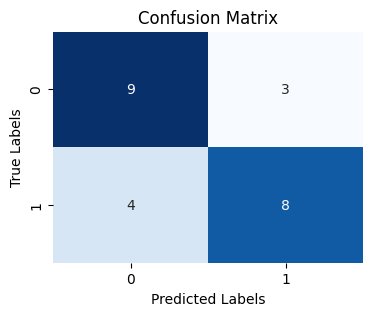


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.73      0.67      0.70        12

    accuracy                           0.71        24
   macro avg       0.71      0.71      0.71        24
weighted avg       0.71      0.71      0.71        24



In [ ]:
evaluate_SVM_model(X_corr, y_corr, n_splits=5)

# train svm on PLI filtered features data

In [ ]:
X_pli = pli_filtered_features.drop(columns=['label'])
y_pli = pli_filtered_features['label']

Fold 1 Accuracy: 0.6000
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 0.8000
Fold 4 Accuracy: 0.6000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.7500

Confusion Matrix:


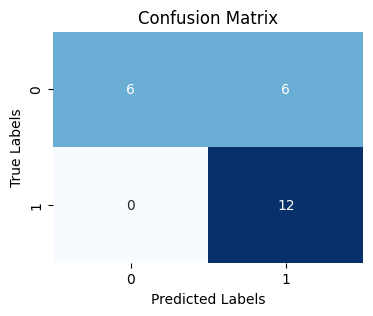


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        12
           1       0.67      1.00      0.80        12

    accuracy                           0.75        24
   macro avg       0.83      0.75      0.73        24
weighted avg       0.83      0.75      0.73        24



In [ ]:
evaluate_SVM_model(X_pli, y_pli, n_splits=5)

# train svm on PLV filtered features data

In [ ]:
X_plv = plv_filtered_features.drop(columns=['label'])
y_plv = plv_filtered_features['label']

Fold 1 Accuracy: 0.4000
Fold 2 Accuracy: 0.6000
Fold 3 Accuracy: 0.4000
Fold 4 Accuracy: 1.0000
Fold 5 Accuracy: 0.5000

Mean Accuracy: 0.5800

Confusion Matrix:


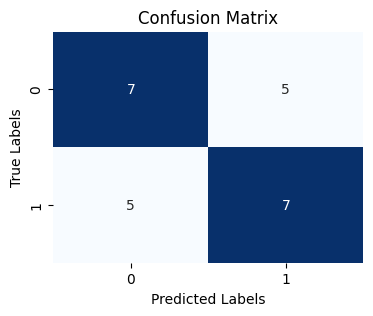


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.58      0.58      0.58        12

    accuracy                           0.58        24
   macro avg       0.58      0.58      0.58        24
weighted avg       0.58      0.58      0.58        24



In [ ]:
evaluate_SVM_model(X_plv, y_plv, n_splits=5)

# train XGBoost model on filtered data

In [ ]:
from xgboost import XGBClassifier

In [ ]:
def evaluate_XGBoost_model(X, y, n_splits=5):

  model = XGBClassifier(eval_metric='logloss', random_state=42)

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  fold_accuracies = []
  all_true = []
  all_pred = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

  print(f"\nMean Accuracy: {np.mean(fold_accuracies):.4f}")

  # plot confusion matrix
  confusion = confusion_matrix(all_true, all_pred)
  print("\nConfusion Matrix:")
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_true, all_pred))


## train XGBoost: on correlation matrices filtered features

Fold 1 Accuracy: 0.8000
Fold 2 Accuracy: 0.6000
Fold 3 Accuracy: 0.4000
Fold 4 Accuracy: 0.6000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.6300

Confusion Matrix:


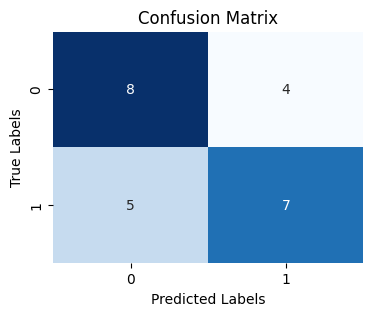


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.64      0.58      0.61        12

    accuracy                           0.62        24
   macro avg       0.63      0.62      0.62        24
weighted avg       0.63      0.62      0.62        24



In [ ]:
evaluate_XGBoost_model(X_corr, y_corr, n_splits=5)

## train XGBoost on PLI filtered features

Fold 1 Accuracy: 0.6000
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 0.8000
Fold 4 Accuracy: 0.8000
Fold 5 Accuracy: 0.5000

Mean Accuracy: 0.7400

Confusion Matrix:


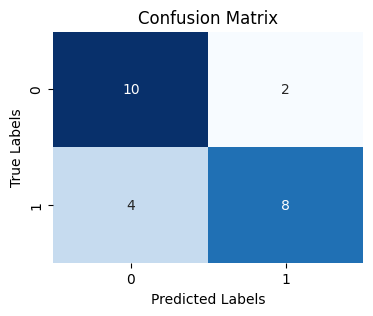


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.80      0.67      0.73        12

    accuracy                           0.75        24
   macro avg       0.76      0.75      0.75        24
weighted avg       0.76      0.75      0.75        24



In [ ]:
evaluate_XGBoost_model(X_pli, y_pli, n_splits=5)

## train XGBoost on PLV filtered features

Fold 1 Accuracy: 0.4000
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 0.4000
Fold 4 Accuracy: 0.6000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.6300

Confusion Matrix:


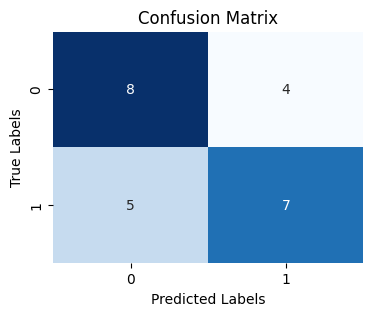


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.64      0.58      0.61        12

    accuracy                           0.62        24
   macro avg       0.63      0.62      0.62        24
weighted avg       0.63      0.62      0.62        24



In [ ]:
evaluate_XGBoost_model(X_plv, y_plv, n_splits=5)

# train Random Forest model on filtered data

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def evaluate_RandomForest_model(X, y, n_splits=5):

  model = RandomForestClassifier(random_state=42)

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  fold_accuracies = []
  all_true = []
  all_pred = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    all_true.extend(y_test)
    all_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {acc:.4f}")

  print(f"\nMean Accuracy: {np.mean(fold_accuracies):.4f}")

  # plot confusion matrix
  confusion = confusion_matrix(all_true, all_pred)
  print("\nConfusion Matrix:")
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

  print("\nClassification Report:")
  print(classification_report(all_true, all_pred))


## train Random Forest on correlation matrices filtered features

Fold 1 Accuracy: 1.0000
Fold 2 Accuracy: 0.8000
Fold 3 Accuracy: 0.6000
Fold 4 Accuracy: 0.8000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.7900

Confusion Matrix:


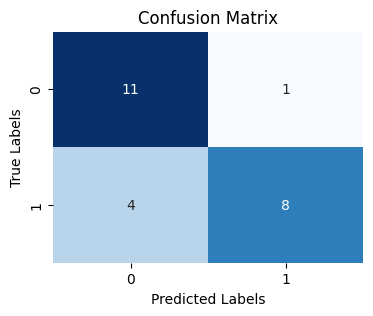


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.89      0.67      0.76        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24



In [ ]:
evaluate_RandomForest_model(X_corr, y_corr, n_splits=5)

## train Random Forest on PLI filtered features

Fold 1 Accuracy: 0.6000
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 0.8000
Fold 4 Accuracy: 0.6000
Fold 5 Accuracy: 0.5000

Mean Accuracy: 0.7000

Confusion Matrix:


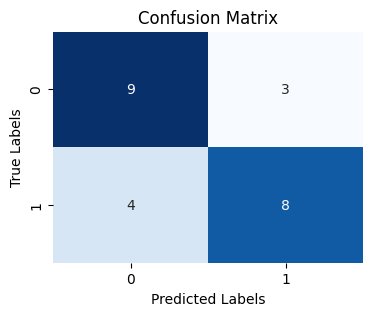


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.73      0.67      0.70        12

    accuracy                           0.71        24
   macro avg       0.71      0.71      0.71        24
weighted avg       0.71      0.71      0.71        24



In [ ]:
evaluate_RandomForest_model(X_pli, y_pli, n_splits=5)

## train Random Forest on PLV filtered features

Fold 1 Accuracy: 0.6000
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 0.6000
Fold 4 Accuracy: 1.0000
Fold 5 Accuracy: 0.7500

Mean Accuracy: 0.7900

Confusion Matrix:


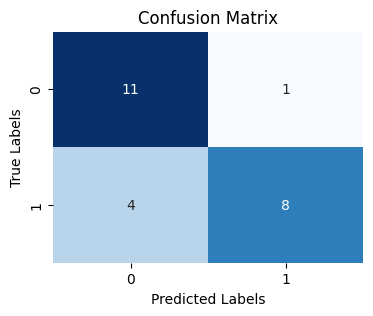


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.89      0.67      0.76        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24



In [ ]:
evaluate_RandomForest_model(X_plv, y_plv, n_splits=5)

**Among three models, Random Forest had better accuracies and among three feature extraction ways PLI had best performance. But among all combinations, combination of Random Forest and PLV had the highest accuracy of 0.97 (The combination of Random Forest and correlation matrices has also accuracy of 0.79), making it the most effective pipeline for classifying EEG data between healthy and disordered infants.**